In [32]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from skimage.morphology import label
from z3 import *

In [33]:
# got the floating islands fixed. Not the continuous see though !

In [34]:
def neighbours(i,j,N):
    return [[i+x,j+y] for (x,y) in [(-1,0),(0,-1),(1,0),(0,1)] if i+x>=0 and i+x <N and j+y>=0 and j+y <N ]
    
def pr(ans,fix):
    n = fix.shape
    annot = fix.astype('str')
    annot[annot=="0"] =""
    fig,ax = plt.subplots(1,1,figsize=(n[0]/3,n[1]/3))
    ax =sns.heatmap(ans !=0,annot=annot,cbar=False,cmap="Greys_r",fmt="",linewidths=1,annot_kws={"size":14},linecolor='k')
    ax.axis("off")
    plt.show()

In [53]:
def sol(fix,tactic):
    start= time.time()
    N = fix.shape[0]
    C = int(np.sum(fix!=0))
    roots = [[i,j,e] for (i,j),e in np.ndenumerate(fix) if e !=0]
    
    s = Tactic(tactic).solver()   
    # Island Number
    X = np.array(IntVector('x', N**2),dtype=object).reshape(N,N)
    # order number in island tree
    Y = np.array(IntVector('y', N**2),dtype=object).reshape(N,N)
        
   
    # limit the grid values to 0 (black) or the island
    s += [And(e>= 0 ,e <=C) for (i,j),e in np.ndenumerate(X)]
    s += [And(e>= 0 ,e <=int(np.max(fix))) for (i,j),e in np.ndenumerate(Y)]
        
    # set the island values for each root
    s += [X[a,b] == n+1 for n,[a,b,x] in enumerate(roots)]
    s += [Y[a,b] == int(x) for n,[a,b,x] in enumerate(roots)]
    
    # make sure the size of each island is correct
    s += [PbEq([(e==n+1,1) for (i,j),e in np.ndenumerate(X)],x) for n,[a,b,x] in enumerate(roots)]
    
    # no 2x2 black
    s += [Implies(e== 0,Or(X[i+1,j] !=0,X[i,j+1] !=0,X[i+1,j+1] !=0)) for (i,j),e in np.ndenumerate(X) if i<N-1 and j<N-1]  
    
    # islands don't touch
    s += [Implies(e > 0,And([Or(X[x,y]==e,X[x,y]==0) for x,y in neighbours(i,j,N)])) for (i,j),e in np.ndenumerate(X)]
   
    # Define a variable to determine if there is an edge between 2 cells
    edge = {}
    for i in range(N):
        for j in range(N):  
            for (k,l) in neighbours(i,j,N) :
                edge[(i,j,k,l)] = Int("e%d%d%d%d" % (i,j,k,l))
                s += Or(edge[(i,j,k,l)] ==0,edge[(i,j,k,l)]==1) 
                
    for i in range(N):
        for j in range(N):  
            for (k,l) in neighbours(i,j,N):
                # Make edges one way to form a tree
                s += (edge[(i,j,k,l)] + edge[(k,l,i,j)]) <= 1
                # Cells with an edge have the same value
                s +=Implies(edge[(k,l,i,j)] == 1,X[i,j] == X[k,l])
    
    # only one edge into each cell
        for i in range(N):
            for j in range(N):  
                # only one edge into each cell
                s += Sum([edge[(k,l,i,j)] for (k,l) in neighbours(i,j,N) ]) <=1
                # root cells have no feeds in
                s += Implies(int(fix[i,j]) !=0, Sum([edge[(k,l,i,j)] for (k,l) in neighbours(i,j,N) ]) == 0)
                # root cells > 1 feed out
                s += Implies(int(fix[i,j]) >1, Sum([edge[(i,j,k,l)] for (k,l) in neighbours(i,j,N) ]) >= 1)
                #filled cells have a feed in
                s+= Implies(X[i,j] !=0 , Or(Sum([edge[(k,l,i,j)] for (k,l) in neighbours(i,j,N)]) == 1,int(fix[i,j]) !=0))
                # edges give decreasing numbers or islands
                s += [Implies(And(X[i,j]!=0,edge[(i,j,k,l)]==1),Y[i,j] > Y[k,l]) for (k,l) in neighbours(i,j,N) ]
                #all cells are connected
                s += Implies(X[i,j]==0,Or([X[k,l]==0  for k,l in neighbours(i,j,N)]))
                # zero cells have a feed in or out
                s += Implies(X[i,j] == 0, Sum([edge[(i,j,k,l)]+edge[(k,l,i,j)] for (k,l) in neighbours(i,j,N) ]) > 0 )
                # only one cell with no feed in
                #s += PbEq([(And(X[i,j] ==0,Sum([edge[(k,l,i,j)] for (k,l) in neighbours(i,j,N) ]) == 0),1) for i in range(N) for k in range(N)],1)
                
                
    # zero cells have island order zero
    s += [Implies(e==0,Y[i,j]==0) for (i,j),e in np.ndenumerate(X)]
    

    
    counter = 0
    while s.check() == sat:
        counter +=1
        print(counter,end=" ")                     
        m = s.model()
        evalu = np.vectorize(lambda x:m.evaluate(x).as_long())
        r =  evalu(X)
        if np.max(label(r== 0,connectivity=1)) == 1:
            print("{}: {} Solved in {:.4f} seconds".format(tactic,tactic_description(tactic),time.time()-start))
            y =  evalu(Y)
            pr(r,fix)
            print(y)
            return r,y
        else:
            s += Or([e!=int(r[i,j]) for (i,j),e in np.ndenumerate(X) ])                     
    else:
        print("fail")    

1 2 3 4 5 6 7 default: default strategy used when no logic is specified. Solved in 1.8664 seconds


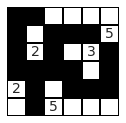

[[0 0 1 2 3 4]
 [0 1 0 0 0 5]
 [0 2 0 1 3 0]
 [0 0 0 0 0 0]
 [2 0 1 0 0 0]
 [1 0 5 3 2 1]]


In [54]:
fix= np.array([[0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 5],
               [0, 2, 0, 0, 3, 0],
               [0, 0, 0, 0, 0, 0],
               [2, 0, 0, 0, 0, 0],
               [0, 0, 5, 0, 0, 0]])

ans,y = sol(fix,"default")


1 2 pqffd: builtin strategy for solving QF_FD problems in parallel. Solved in 3.9421 seconds


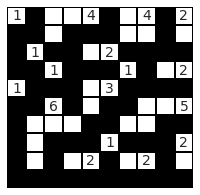

[[1 0 1 2 4 0 1 4 0 2]
 [0 0 0 0 0 0 1 2 0 1]
 [0 1 0 0 0 2 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 2]
 [1 0 0 0 2 3 0 0 0 0]
 [0 0 6 0 0 0 0 3 4 5]
 [0 2 4 1 0 0 1 2 0 0]
 [0 1 0 0 0 1 0 0 0 2]
 [0 0 0 1 2 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


In [55]:
fix2= np.array([[1, 0, 0, 0, 4, 0, 0, 4, 0, 2],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 1, 0, 0, 0, 2, 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0, 1, 0, 0, 2],
                [1, 0, 0, 0, 0, 3, 0, 0, 0, 0],
                [0, 0, 6, 0, 0, 0, 0, 0, 0, 5],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 1, 0, 0, 0, 2],
                [0, 0, 0, 0, 2, 0, 0, 2, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


ans = sol(fix2,"pqffd")

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 pqffd: builtin strategy for solving QF_FD problems in parallel. Solved in 139.6812 seconds


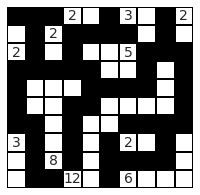

[[ 0  0  0  2  0  0  3  2  0  2]
 [ 0  0  2  0  0  0  0  0  0  1]
 [ 2  0  0  0  2  3  5  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  1  0]
 [ 0  0  2  0  0  5  4  3  2  0]
 [ 0  0  6  0  7  6  0  0  0  0]
 [ 3  0  7  0  8  0  2  0  0  0]
 [ 2  0  8  0  9  0  0  0  0  1]
 [ 0  0  0 12 10  0  6  5  3  2]]


In [56]:
fix3=np.array([[0, 0, 0, 2, 0, 0, 3, 0, 0, 2],
               [0, 0, 2, 0, 0, 0, 0, 0, 0, 0],
               [2, 0, 0, 0, 0, 0, 5, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
               [3, 0, 0, 0, 0, 0, 2, 0, 0, 0],
               [0, 0, 8, 0, 0, 0, 0, 0, 0, 0],
               [0, 0, 0,12, 0, 0, 6, 0, 0, 0]])

ans = sol(fix3,"pqffd")